In [14]:
#CREAR UN INDEX PARA ALMACENAR LOS DATOS
from elasticsearch import Elasticsearch
from pprint import pprint

es = Elasticsearch()

if not(es.indices.exists(index="tp5-championstweet")):
    res = es.indices.create(index="tp5-championstweet")  
    pprint(res)

{'acknowledged': True,
 'index': 'tp5-championstweet',
 'shards_acknowledged': True}


In [15]:
#LISTAR LOS ARCHIVOS DEL DATASET
import json
import os
files = os.listdir("split_dataset_1")
pprint(len(files))

354585


In [17]:
from elasticsearch import helpers

#CARGAR LOS DATOS EN ELASTICSEARCH
tweets=[]

for filename in files:
    with open('split_dataset_1/'+filename) as f:
        try:
            #pprint(filename+':')
            tweet = json.load(f)
            timestamp=int(tweet["timestamp_ms"])
            #pprint(tweet)
            simple_tweet = {
                "timestamp":timestamp, \
                "date":tweet["created_at"], \
               "text": tweet['text'], \
               "username": tweet['user']['name'], \
               "location": tweet['user']['location']}
        except KeyError:
            error="error"
            
    tweets.append(simple_tweet)#remove comment
    
    #CARGAMOS LOS DATOS EN ELASTICSEARCH CON CONSULTAS 'BULK' PARA OPTIMIZAR EL PROCESO
    if (len(tweets)>=1000):
        i=0
        docs_as_string="["
        while i<1000:
            if i!=0:
                docs_as_string = docs_as_string + ','
            docs_as_string = docs_as_string + '\n' + json.dumps(tweets[i])
            i=i+1
        docs_as_string=docs_as_string+"]"
        res = helpers.bulk(es, json.loads(docs_as_string),index="tp5-championstweet", doc_type="_doc")
        tweets=[]

In [74]:
#CONSULTA BÁSICA A ELASTICSEARCH PARA PROBAR
res = es.search(index="tp5-championstweet", body={"query": {"match_all": {}}})
print("Got %d Hits:" % res['hits']['total'])
for hit in res['hits']['hits']:
    print("TWEET:%(text)s %(username)s: %(date)s" % hit["_source"])

Got 354000 Hits:
TWEET:oh wow. Just as a human being this is heartbreaking to watch, this was his moment, he deserved it. Sorry Mo. #UCLfinal Nate: Sat May 26 19:17:06 +0000 2018
TWEET:Liverpool looks like like they are up for it #UCLfinal Anni: Sat May 26 18:55:45 +0000 2018
TWEET:RT @IamNestorDavid: OH POR DIOS SANTOOOOOOO!!!!

R E C O N T R A    G O L A Z O!! 😱😱😱😱😱😱😱😱😱😱😱😱😱😱😱😱😱😱😱😱😱😱

@GarethBale11 GOOOOOOOOOOOOOLAAAA… Jorge Isaac 🏌🏻‍♂️: Sat May 26 20:09:46 +0000 2018
TWEET:RT @ElieHHaddad: Honestly, that was a disgrace from Sergio Ramos. He's ended @MoSalah night and possibly his World Cup with a cynical, horr… Peter green j: Sat May 26 19:33:20 +0000 2018
TWEET:RT @EvradB: Take a break Donald, and watch #UCLfinal https://t.co/sykS62ueuN Prince Opportunistic: Sat May 26 19:50:12 +0000 2018
TWEET:RT @AnthonyShackels: THAT TRANSITION WAS EVERYTHING BABE @DUALIPA #UCLFinal https://t.co/pGODbbsPG6 Emily: Sat May 26 19:26:39 +0000 2018
TWEET:that was scorcher from Bale!!  #UCLfinal 
#UCLF

In [68]:
#CONSULTA: ¿Cuántos tweets cada minuto?
res = es.search(index="tp5-championstweet", body={"aggs" : { "tweets_over_time" : \
                                                            { "date_histogram" : { "field" : \
                                                                                  "timestamp", "interval" : "1m" \
                                                                                 }}}})
#for data in res['aggregations']['tweets_over_time']['buckets']:
#    print(data['doc_count'])

In [69]:
import pandas as pd

df_tweetsByMinutes = pd.DataFrame(res['aggregations']['tweets_over_time']['buckets'])
df_tweetsByMinutes = df_tweetsByMinutes.rename(columns={'key': 'timestamp', 'doc_count': 'nb_tweets'})
df_tweetsByMinutes[:10]

,nb_tweets,timestamp
0,41,1527340680000
1,0,1527340740000
2,0,1527340800000
3,0,1527340860000
4,0,1527340920000
5,0,1527340980000
6,0,1527341040000
7,0,1527341100000
8,0,1527341160000
9,0,1527341220000


In [70]:
df_tweetsByMinutes_filtered = df_tweetsByMinutes.drop(df_tweetsByMinutes[df_tweetsByMinutes.timestamp < 1527357600000 ].index)
df_tweetsByMinutes_filtered[:10]

,nb_tweets,timestamp
282,0,1527357600000
283,0,1527357660000
284,0,1527357720000
285,0,1527357780000
286,0,1527357840000
287,0,1527357900000
288,0,1527357960000
289,0,1527358020000
290,0,1527358080000
291,0,1527358140000


In [72]:
import datetime

def timestamp2date(x):
    y = datetime.datetime.fromtimestamp(x/1000).strftime('%H:%M:%S')
    return y

df_tweetsByMinutes_filtered['timestamp']=df_tweetsByMinutes_filtered['timestamp'].apply(timestamp2date)
df_tweetsByMinutes_filtered[:10]

,nb_tweets,timestamp
282,0,14:00:00
283,0,14:01:00
284,0,14:02:00
285,0,14:03:00
286,0,14:04:00
287,0,14:05:00
288,0,14:06:00
289,0,14:07:00
290,0,14:08:00
291,0,14:09:00


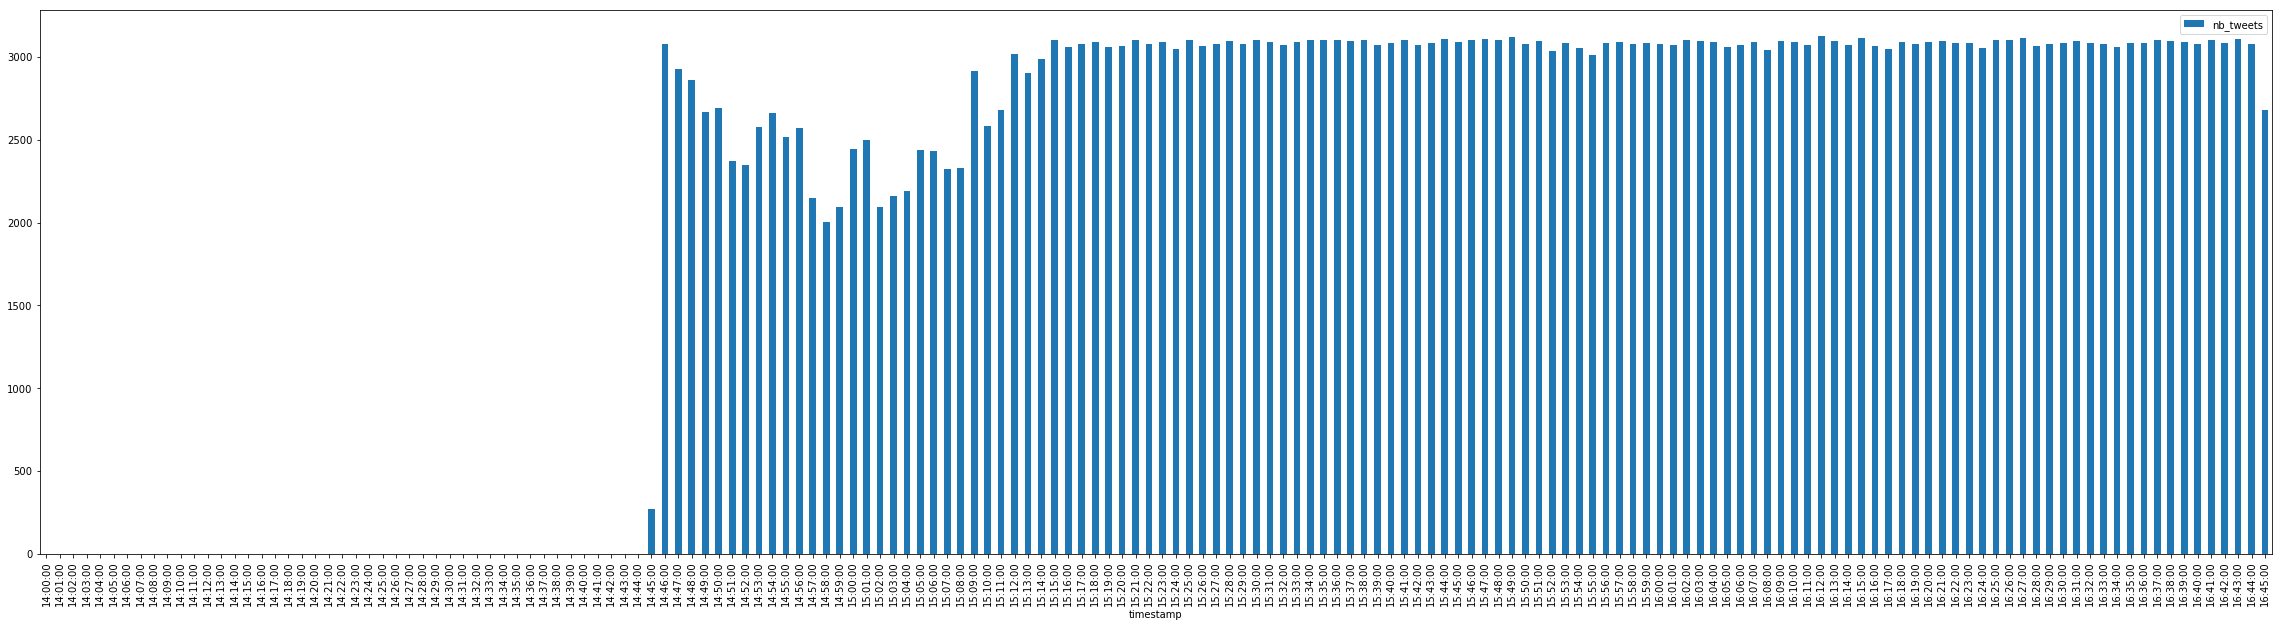

In [73]:
import matplotlib.pyplot as plt
%matplotlib inline

df_tweetsByMinutes_filtered.plot(kind='bar',figsize=(40,10), fontsize=10, x='timestamp')
plt.show()

In [82]:
#CONSULTA BÁSICA A ELASTICSEARCH PARA PROBAR
res = es.search(index="tp5-championstweet", body={"query": {"term":{"text":"goal"}}})
print("Got %d Hits:" % res['hits']['total'])
for hit in res['hits']['hits']:
    print("TWEET:%(text)s %(username)s: %(date)s" % hit["_source"])

Got 16771 Hits:
TWEET:Goal goal goal goal goal goal!!!!!!!!!!!!!!!!!!!!!! #RealMadrid #RMALIV #UCLfinal Preveza Epirus: Sat May 26 20:13:28 +0000 2018
TWEET:Goal 
Goal
Goal
Goal
#UCLfinal Olouwadamissi: Sat May 26 19:57:14 +0000 2018
TWEET:GOAL GOAL GOAL GOAL GOOOAAAAL MANEEEEE #UCLFinal NooR: Sat May 26 20:01:07 +0000 2018
TWEET:Super goal goal goal goal goal https://t.co/FVh1CVOEGA Abouuuuuuuuuuuuu Impala: Sat May 26 20:12:56 +0000 2018
TWEET:Goal! Goal!! Goal!!! Sadio Mane #UCLfinal P!: Sat May 26 20:00:31 +0000 2018
TWEET:Goal! Goal! Goal! Typical Liverpool goalkeepers #UCLfinal #HalaMadrid Tlholo conquer: Sat May 26 19:56:24 +0000 2018
TWEET:Goal Goal Goal!!!!! 
@KraksTV 
#UCLFinal https://t.co/H8cDjge8hi Unilag Ajebutter: Sat May 26 19:56:06 +0000 2018
TWEET:Yeyyyy😃😃 goal ,goal😃😃😃
#UCLfinal A girl with a brain without mind.: Sat May 26 20:25:25 +0000 2018
TWEET:#UCLfinal

Never felt this alive. Goal goal goal Gagan: Sat May 26 20:01:30 +0000 2018
TWEET:Mane goal issa goal #uclfin